<a href="https://colab.research.google.com/github/Marsobad/ADL/blob/master/TP2_Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we use Grad-CAM, which highlights the regions of the input image that were important for the neural network prediction.

* **To be submitted by next session**: this notebook, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [0]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline

### Download the Model
We provide you a pretrained model `VGG-16` for `ImageNet` classification dataset.
* **ImageNet**: A large dataset of photographs with 1 000 classes.
* **VGG-16**: A deep architecture for image classification.

![vgg_16.png](https://www.researchgate.net/profile/Bibo_Shi/publication/323440752/figure/fig1/AS:739814685032448@1553396974148/The-architecture-of-VGG-16-model-To-represent-different-depth-levels-convolutional.jpg)

In [0]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.

### Input Images
We provide you 20 images from ImageNet (download link on the webpage of the course; notice that the images should be placed in a **sub**-directory of the path indicated below).<br>
In order to use the pretrained model vgg-16, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(224, 224)`.

In [0]:
# The downloading process may take a few minutes. 
vgg_model = models.vgg16(pretrained=True)# return the vgg-16 model pretrained on ImageNet dataset.
# Define preprocessing function of the input images
def preprocess_image(dir_path):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor

    return (dataset)
# The images should be in a *sub*-folder of "data/" (ex: data/TP2_images/images.jpg) and *not* directly in "data/"!
# otherwise the function won't find them
dir_path = "/data" 
dataset = preprocess_image(dir_path)

In [0]:
def grad_cam(image_index):
  image_origin = dataset[image_index][0]
  image_resized = torch.nn.functional.interpolate(image_origin.unsqueeze(0), (224,224),mode='bicubic')
  plt.figure()
  plt.imshow(image_resized[0][0].detach())

  output = vgg_model(dataset[image_index][0].view(1, 3, 224, 224))
  top3_classes = torch.topk(output, 3)[1].numpy()[0]

  for class_nb in [281,282,283]:#top3_classes:
    target_activity = None
    activities = get_activities(class_nb,image_index)
    target_grad = None
    features_importance = get_features_importance(class_nb,image_index)
    product = features_importance.view(1,512,1,1)*activities
    heatmap = torch.relu(torch.mean(product,1))
    heatmap_resized = torch.nn.functional.interpolate(heatmap.unsqueeze(0), (224,224),mode='bicubic')
    plt.figure()
    plt.imshow(heatmap_resized[0][0].detach())


In [0]:
def get_features_importance(class_nb,index):
  def printgradnorm(self, grad_input, grad_output):
    global target_grad
    target_grad = grad_output[0] 

  handler = vgg_model.features[28].register_backward_hook(printgradnorm)
  image = dataset[index][0].view(1, 3, 224, 224)
  output = vgg_model(image)

  for i in range(len(output[0])):
    if i != class_nb: 
      output[0][i].zero_()

  output[0][class_nb].backward()

  average_gradient_per_feature_y = torch.mean(target_grad,2)
  average_gradient_per_feature = torch.mean(average_gradient_per_feature_y,2)
  handler.remove()
  return average_gradient_per_feature


In [0]:
def get_activities(target_class,index):
  #target_activity=None
  def printnorm(self, input, output):
    global target_activity
    target_activity = input[0]

  handler_forward = vgg_model.features[28].register_forward_hook(printnorm)
  image = dataset[index][0].view(1, 3, 224, 224)
  output = vgg_model(image)
  
  for i in range(len(output[0])):
    if i != target_class: 
      output[0][i].zero_()

  output[0][target_class].backward()

  handler_forward.remove()
  return target_activity

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


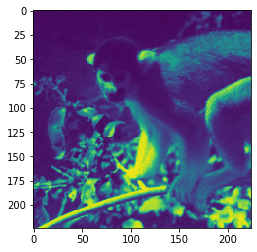

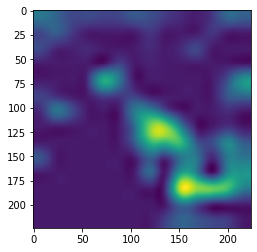

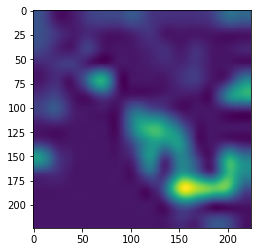

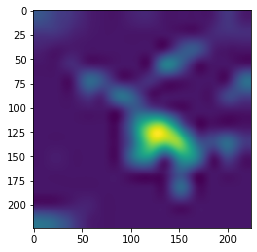

In [10]:
grad_cam(19)

### Grad-CAM 
* **Overview:** Given an image, and a category (‘tiger cat’) as input, we forward-propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (tiger cat), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the given images. For each image, choose the top-3 possible labels as the desired classes. Compare the heatmaps of the three classes, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model vgg-16 doesn't have an activation function after its last layer, the output is indeed the `raw class scores`, you can use them directly. Run `print(vgg_model)` to get more information on VGG model.
 + The size of feature maps is 14x14, so your heatmap will have the same size. You need to project the heatmap to the resized image (224x224, not the original one, before the normalization) to have a better observation. The function [`torch.nn.functional.interpolate`](https://pytorch.org/docs/stable/nn.functional.html?highlight=interpolate#torch.nn.functional.interpolate) may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)